# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = "B1"
TEST_TILE = 50
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI"]
CHANNEL_CMAPS = ["pure_blue"]

# parameters for feature extraction
FOCI_CHANNEL = None

Loading test image...
Applying illumination correction...
Example corrected image:


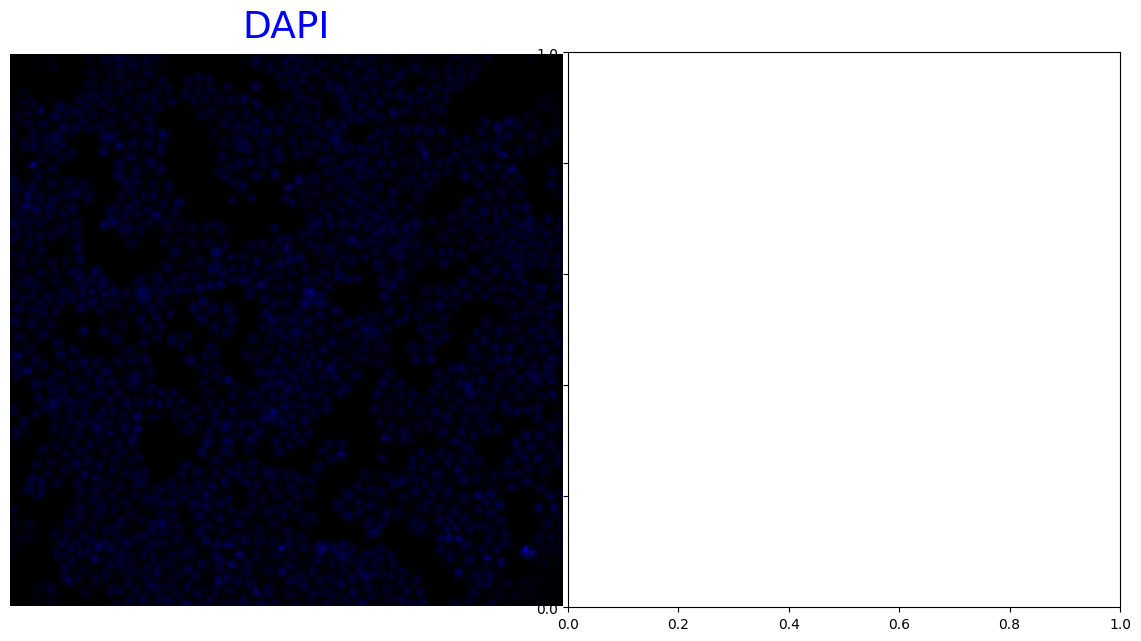

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Name of the channel that other channels will be aligned to.
- `SOURCE`: Name of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [5]:
# Set alignment parameters
ALIGN = None
TARGET = None
SOURCE = None
RIDERS = None
REMOVE_CHANNEL = None

# Derive alignment indexes
if ALIGN:
    TARGET_INDEX = CHANNEL_NAMES.index(TARGET)
    SOURCE_INDEX = CHANNEL_NAMES.index(SOURCE)
    RIDER_INDEXES = [CHANNEL_NAMES.index(r) for r in RIDERS]

In [6]:
if ALIGN:
    print("Aligning channels...")
    aligned_image = align_phenotype_channels(
        corrected_image,
        target=TARGET_INDEX,
        source=SOURCE_INDEX,
        riders=RIDER_INDEXES,
        remove_channel=REMOVE_CHANNEL,
    )
    # Automatically remove channels based on REMOVE_CHANNEL
    if REMOVE_CHANNEL == "source":
        remove_index = CHANNEL_NAMES.index(SOURCE)
        CHANNEL_NAMES.pop(remove_index)
        CHANNEL_CMAPS.pop(remove_index)
    elif REMOVE_CHANNEL == "target":
        remove_index = CHANNEL_NAMES.index(TARGET)
        CHANNEL_NAMES.pop(remove_index)
        CHANNEL_CMAPS.pop(remove_index)
    elif REMOVE_CHANNEL == "riders":
        # Remove riders in reverse order to maintain correct indices
        for rider in reversed(RIDERS):
            remove_index = CHANNEL_NAMES.index(rider)
            CHANNEL_NAMES.pop(remove_index)
            CHANNEL_CMAPS.pop(remove_index)
else:
    aligned_image = corrected_image

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `CELL_FLOW_THRESHOLD` & `NUCLEI_FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELL_CELLPROB_THRESHOLD` & `NUCLEI_CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically, but can be manually overridden.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `CELL_PROB_THRESHOLD` & `NUCLEI_PROB_THRESHOLD`: Probability threshold for segmentation. Default is 0.479071.
- `CELL_NMS_THRESHOLD` & `NUCLEI_NMS_THRESHOLD`: Non-maximum suppression threshold. Default is 0.3.

#### Watershed Parameters (if using "watershed")
- `THRESHOLD_DAPI`: Threshold for nuclei segmentation. 
- `THRESHOLD_CELL`: Threshold for cell boundary segmentation.
- `NUCLEUS_AREA`: Range for filtering nuclei by area as a tuple (min, max).

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [7]:
# Common parameters
CYTO_CHANNEL = "DAPI"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import estimate_diameters
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0.0
    CELL_FLOW_THRESHOLD = 1
    CELL_CELLPROB_THRESHOLD = 0

    print("Estimating optimal cell and nuclei diameters...")
    NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        cyto_model=CELLPOSE_MODEL,
    )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    NUCLEI_PROB_THRESHOLD = 0.479071
    NUCLEI_NMS_THRESHOLD = 0.3
    CELL_PROB_THRESHOLD = 0.479071
    CELL_NMS_THRESHOLD = 0.3

Estimating optimal cell and nuclei diameters...


/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_pumori/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Estimating nuclei diameters...
Estimated nuclear diameter: 20.0 pixels
Estimating cell diameters...
Estimated cell diameter: 38.0 pixels


Segmenting image with cellpose...


found 1452 nuclei before removing edges
found 1481 cells before removing edges
found 1389 nuclei before reconciling
found 1359 cells before reconciling


removing edges
reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 24
Cells with 1 nuclei: 1313
Cells with 2 nuclei: 21
Cells with 4 nuclei: 1
--------------------------



found 1335 nuclei/cells after reconciling


Number of nuclei segmented: 1335
Number of cells segmented: 1335
Example microplots for DAPI channel and nuclei segmentation:


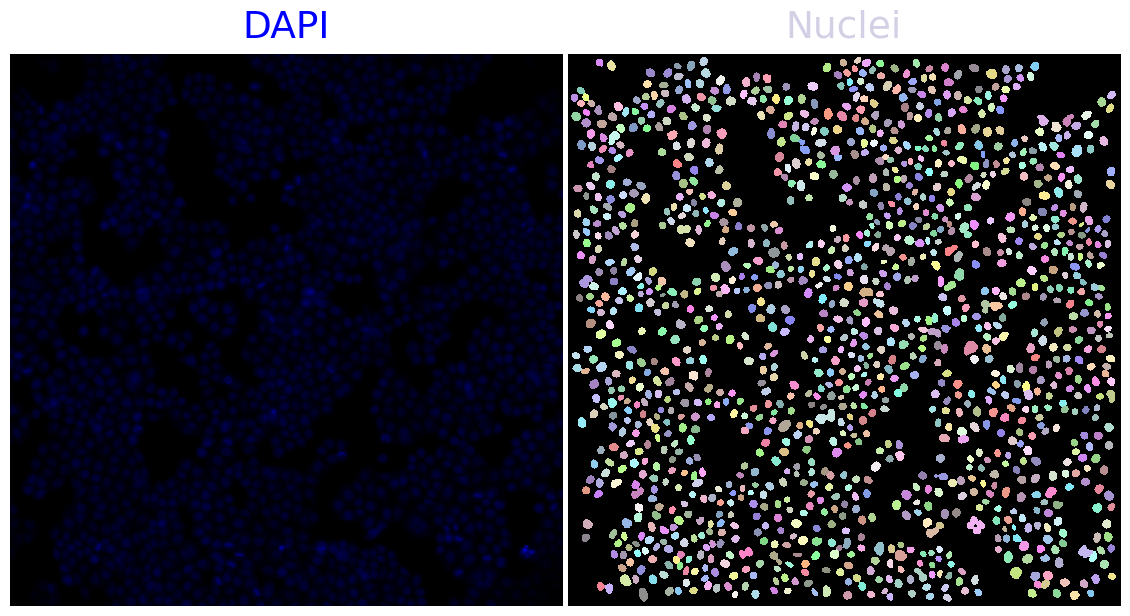

Example microplots for merged channels and cells segmentation:


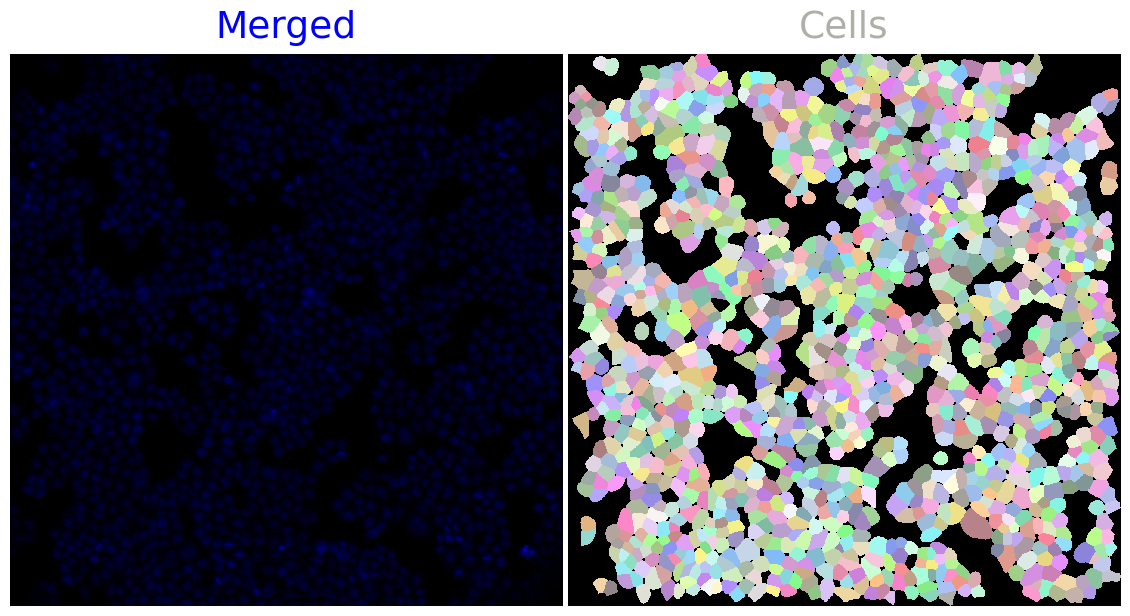

Example microplot for phenotype data annotated with segmentation:


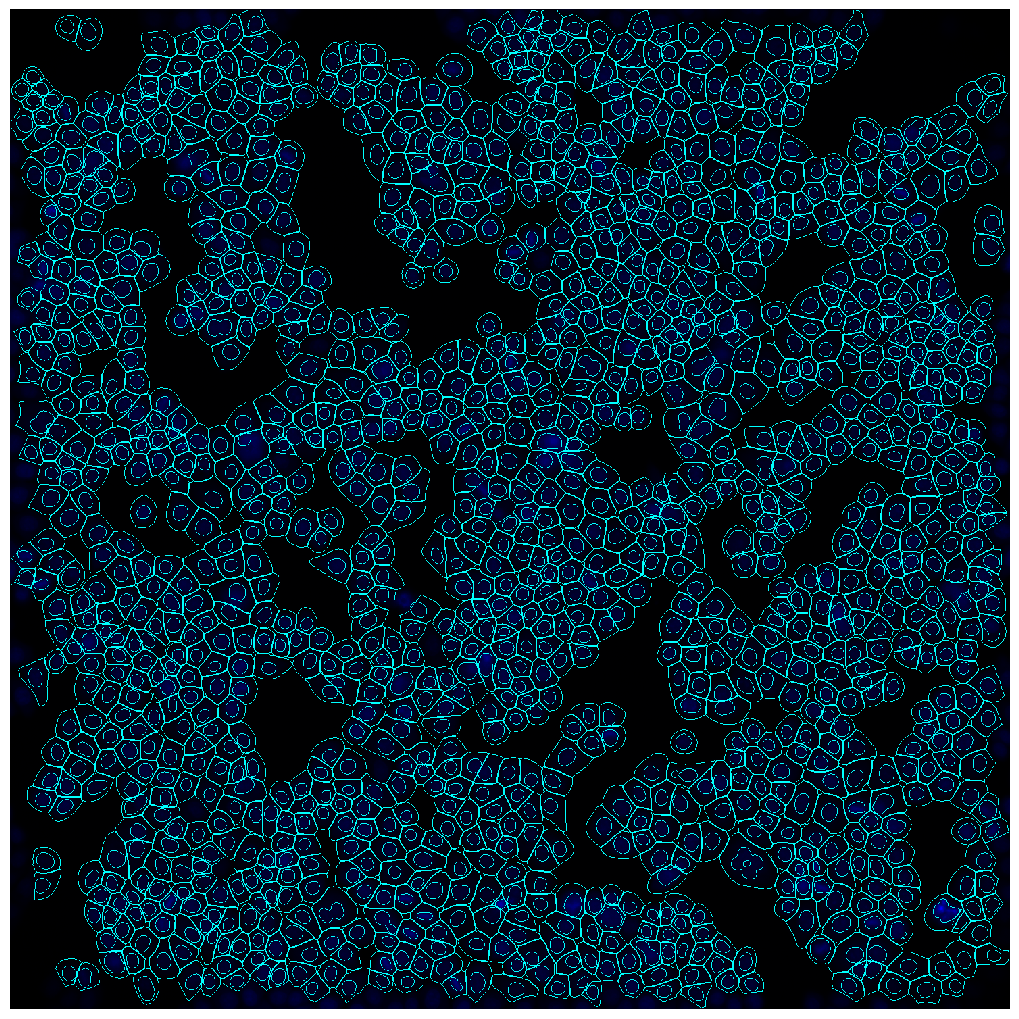

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1335


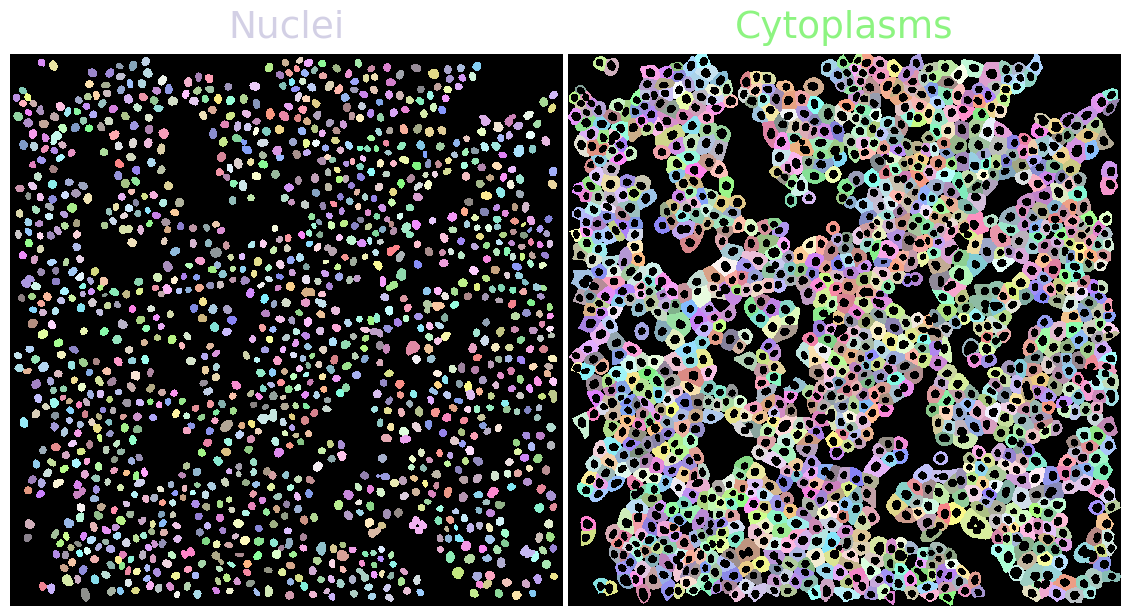

In [8]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import segment_cellpose
    nuclei, cells = segment_cellpose(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    from lib.shared.segment_microsam import segment_microsam
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    from lib.shared.segment_stardist import segment_stardist
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Feature extraction

- `CP_METHOD`: Methodology for phenotype feature extraction.  
    - `cp_multichannel`: Use emulated code from original _Feldman et. al. 2019_ to extract CellProfiler-like features.
    - `cp_measure`: Use Pythonic version of [CellProfiler](https://github.com/afermg/cp_measure) directly from Imaging Platform. Still in development, may run slowly in Jupyter notebook for testing purposes.

  #### BEFORE USING CP MEASURE
Ensure your current conda environment is set up for cp_measure when using this method. This can be done in the following manner:
1. Clone brieflow environment:

   `conda create --name brieflow_cpmeasure_env --clone brieflow_main_env`

2. Activate the environment:

    `conda activate brieflow_cpmeasure_env`

3. Install the required package:

    `pip install cp-measure`

4. Verify dependencies with `conda list` - cp_measure requires Python 3.8 or later, and the following package versions:

    - NumPy 1.24.3*
    - centrosome 1.3.0*
    
   If you have issues running cp_measure, you may need to downgrade these packages in the cloned environment.

In [9]:
CP_METHOD = "cp_multichannel"

In [10]:
print("Extracting phenotype features:")
if CP_METHOD == "cp_measure":
    from lib.phenotype.extract_phenotype_cp_measure import extract_phenotype_cp_measure
    # Extract features using cp_measure
    phenotype_cp = extract_phenotype_cp_measure(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        cytoplasms=cytoplasms,
        channel_names=CHANNEL_NAMES,
    )
else:
    from lib.phenotype.extract_phenotype_cp_multichannel import (
        extract_phenotype_cp_multichannel,
    )
    # extract phenotype CellProfiler information
    phenotype_cp = extract_phenotype_cp_multichannel(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        wildcards=WILDCARDS,
        cytoplasms=cytoplasms,
        foci_channel=FOCI_CHANNEL,
        channel_names=CHANNEL_NAMES,
    )

phenotype_cp

Extracting phenotype features:


,label,well,tile,nucleus_i,nucleus_j,nucleus_bounds_0,nucleus_bounds_1,nucleus_bounds_2,nucleus_bounds_3,cell_i,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,B1,50,22.350348,362.452436,10,351,35,374,20.139351,...,0.083312,0.073509,0.030613,0.046739,0.021450,2,0.320755,36.145698,36.765393,87.394866
1,2,B1,50,26.436916,797.899533,16,786,38,810,19.986201,...,0.046981,0.161934,0.035907,0.079052,0.053156,5,0.491304,26.089631,34.231670,115.842785
2,3,B1,50,35.063877,1249.037445,23,1237,48,1261,32.208945,...,0.096681,0.045987,0.046793,0.057841,0.047228,2,0.172078,41.186201,48.018688,54.234715
3,4,B1,50,19.298893,775.420664,10,766,29,785,17.048701,...,0.097207,0.083401,0.077202,0.032037,0.031719,2,0.338624,26.089631,27.960526,104.021730
4,5,B1,50,27.105850,931.988858,16,922,39,943,25.570863,...,0.104490,0.048880,0.039730,0.013094,0.008663,4,0.250000,39.050263,42.403779,116.479682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,1331,B1,50,1451.128146,748.224256,1440,737,1463,761,1446.977836,...,0.184766,0.044092,0.031438,0.029709,0.052100,3,0.261538,29.398295,46.531843,64.787003
1331,1332,B1,50,1450.962656,1355.338174,1440,1343,1464,1369,1451.166366,...,0.091472,0.052010,0.024440,0.024553,0.073610,4,0.354949,40.612285,41.564979,50.186895
1332,1333,B1,50,1453.284431,968.517964,1444,958,1463,980,1451.353377,...,0.129693,0.065812,0.100427,0.087216,0.027692,4,0.315589,23.177129,46.276266,89.273847
1333,1334,B1,50,1454.667742,861.829032,1445,852,1466,872,1456.150943,...,0.173843,0.069638,0.067377,0.029641,0.019837,2,0.176768,29.646508,44.944019,79.945258


In [11]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',
 'cell_j',
 'cell_lower_quartile',
 'cell_mad',
 'cell_major_axis',
 '

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of parameters for segmentation accuracy. This is not yet implemented.

In [12]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "cp_method": CP_METHOD,
    "mode": None,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "nuclei_prob_threshold": NUCLEI_PROB_THRESHOLD,
        "nuclei_nms_threshold": NUCLEI_NMS_THRESHOLD,
        "cell_prob_threshold": CELL_PROB_THRESHOLD,
        "cell_nms_threshold": CELL_NMS_THRESHOLD,
    })

if ALIGN:  # then add the source index, rider indexes, and remove index
    config["phenotype"]["target"] = TARGET_INDEX
    config["phenotype"]["source"] = SOURCE_INDEX
    config["phenotype"]["riders"] = RIDER_INDEXES
    config["phenotype"]["remove_channel"] = REMOVE_CHANNEL

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)